In [47]:
class Category:
    BOOKS = 'BOOKS'
    CLOTHING = 'CLOTHING'
    ELECTRONICS = 'ELECTRONICS'
    GROCERY = 'GROCERY'
    PATIO = 'PATIO'
    
class Sentiment:
    POSITIVE = 'POSITIVE'
    NEGATIVE = 'NEGATIVE'
    NEUTRAL = 'NEUTRAL'
    
class Review:
    def __init__(self, category, text, score) -> None:
        self.category = category
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else:
            return Sentiment.POSITIVE
        
class ReviewContainer:
    def __init__(self, reviews) -> None:
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_category(self):
        return [x.category for x in self.reviews]
    
    def get_x(self, vectorizer):
        return vectorizer.transform(self.get_text())
    
    def get_y(self):
        return [x.sentiment for x in self.reviews]

## Load Data

In [48]:
import json

path_file = ['data/category/Books_small.json', 'data/category/Clothing_small.json', 'data/category/Electronics_small.json', 'data/category/Grocery_small.json', 'data/category/Patio_small.json']
file_categories = [Category.BOOKS, Category.CLOTHING, Category.ELECTRONICS, Category.GROCERY, Category.PATIO]

reviews = []
for i in range(len(path_file)):
    file = path_file[i]
    category = file_categories[i]
    with open(file) as f:
        for line in f:
            reviews_json = json.loads(line)
            review = Review(category, reviews_json['reviewText'], reviews_json['overall'])
            reviews.append(review)


## Prep Data

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

train, test = train_test_split(reviews, test_size=0.33, random_state=42)

train_container = ReviewContainer(train)
test_container = ReviewContainer(test)

# Make Bag Of Worlds
corpus = train_container.get_text()
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)

TfidfVectorizer()

In [66]:
# Transform data using vectorizer
train_x = train_container.get_x(vectorizer)
train_y = train_container.get_category()

test_x = test_container.get_x(vectorizer)
test_y = test_container.get_category()

## Classification

In [70]:
from sklearn.svm import SVC

clf = SVC(C=16, kernel='linear', gamma='auto')
clf.fit(train_x, train_y)

SVC(C=16, gamma='auto', kernel='linear')

In [71]:
test_set = ['great for my wedding', "loved it in my garden", 'good computer']
new_test = vectorizer.transform(test_set)

clf.predict(new_test)

array(['ELECTRONICS', 'PATIO', 'ELECTRONICS'], dtype='<U11')

In [72]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

# print(train_x)
gnb.fit(train_x.todense(),train_y)
gnb.score(test_x.todense(),test_y)

/home/tinapyp/Dependencies/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:723: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/tinapyp/Dependencies/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:723: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.8109090909090909

## Performance

In [75]:
from sklearn.metrics import f1_score

y_pred = clf.predict(test_x)
f1_score = f1_score(test_y, y_pred, average=None)

print('f1_score', f1_score)

f1_score [0.95393759 0.89795918 0.88217523 0.89953632 0.90822785]


In [76]:
clf.score(test_x, test_y)

0.9084848484848485

## Tuning using Grid Search

In [77]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,1,8,16,32]}
svc = SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 8, 16, 32], 'kernel': ('linear', 'rbf')})

In [78]:
clf.score(test_x, test_y)

0.916969696969697

## Save Model

In [79]:
import pickle

with open('models/category_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)
    
with open('models/category_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

### Load Model

In [80]:
import pickle 

with open('models/category_classifier.pkl', 'rb') as f:
    clf = pickle.load(f)

with open('models/category_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

In [81]:
test_set = ['very quick speeds', "loved the necklace", 'bad']
new_test = vectorizer.transform(test_set)

clf.predict(new_test)

array(['BOOKS', 'CLOTHING', 'GROCERY'], dtype='<U11')

## Confusion Matrix

<Axes: >

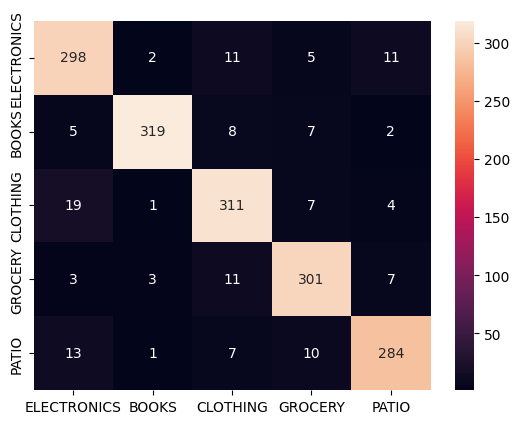

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

y_pred = clf.predict(test_x)

labels = [Category.ELECTRONICS, Category.BOOKS, Category.CLOTHING, Category.GROCERY, Category.PATIO]

cm = confusion_matrix(test_y, y_pred, labels=labels) ;cm
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')